
STEP 1: COMBINING CSV FILES
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4321 CSV files

Combining CSV files...
  Processing file 0/4321...
  Processing file 500/4321...
  Processing file 1000/4321...
  Processing file 1500/4321...
  Processing file 2000/4321...
  Processing file 2500/4321...
  Processing file 3000/4321...
  Processing file 3500/4321...
  Processing file 4000/4321...

✅ Combined dataset shape: (870903, 24)
Total rows: 870,903
Total columns: 24
✅ Saved: combined_dataset.csv

Column names and types:
time_start             object
time_end               object
scenario_id            object
ue_total               object
attackers              object
src_ip                 object
dst_ip                 object
src_port               object
dst_port               object
protocol               object
packet_size           float64
flow_duration          object
total_bytes_fwd        object

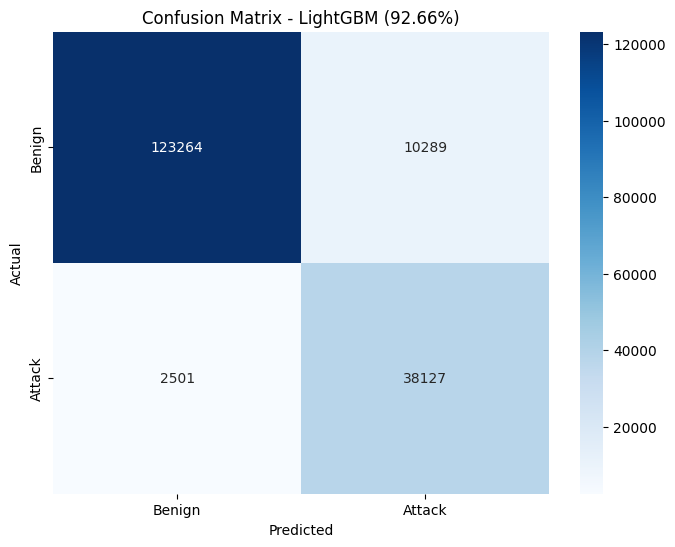

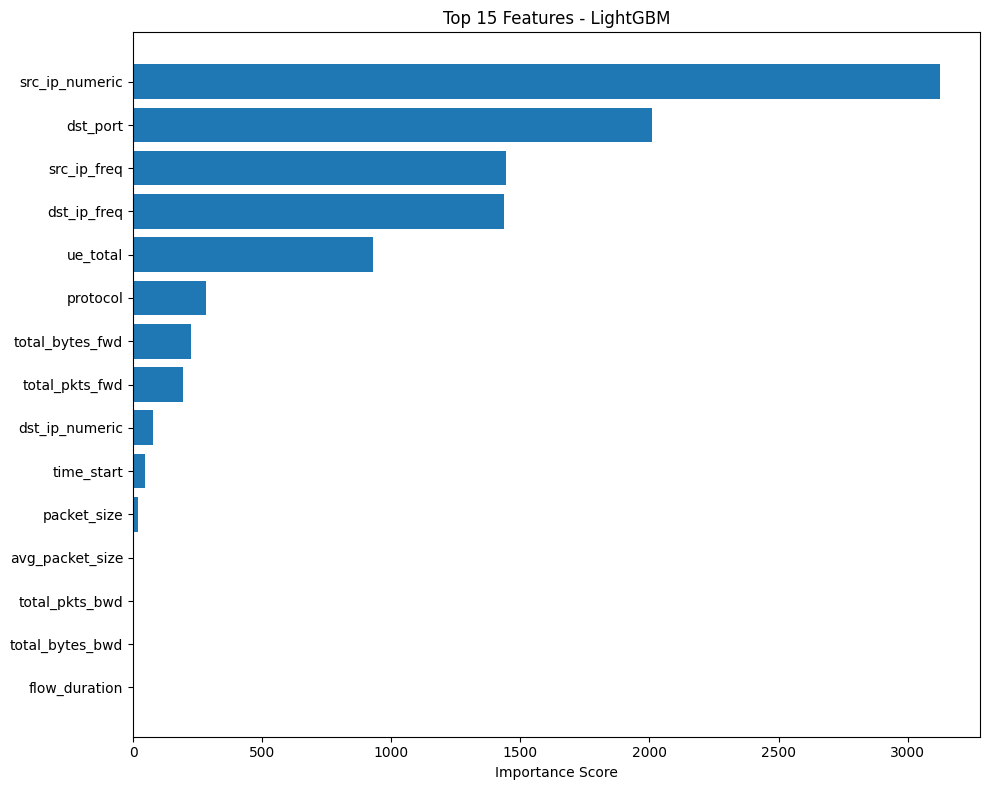


Top 10 Most Important Features:
  src_ip_numeric: 3124.0000
  dst_port: 2010.0000
  src_ip_freq: 1446.0000
  dst_ip_freq: 1438.0000
  ue_total: 931.0000
  protocol: 283.0000
  total_bytes_fwd: 226.0000
  total_pkts_fwd: 192.0000
  dst_ip_numeric: 78.0000
  time_start: 48.0000

STEP 9: SAVING MODEL & COMPONENTS
✅ Model saved: /content/drive/MyDrive/colab/best_model_lightgbm_92.7.pkl
✅ Scaler saved: /content/drive/MyDrive/colab/scaler.pkl
✅ Feature names saved: /content/drive/MyDrive/colab/features.txt
⚠️ Could not save to Google Drive

PIPELINE COMPLETE - SUMMARY

📊 DATASET:
-----------
• Total samples: 870,903
• Training samples: 696,722
• Test samples: 174,181
• Features used: 28
• Attack percentage: 23.33%

🏆 BEST MODEL: LightGBM
-----------
• Accuracy: 92.66%
• Cross-validation: 92.62% ± 0.08%

📈 PERFORMANCE:
-----------
• True Positives (Attacks detected): 38,127
• True Negatives (Benign correct): 123,264
• False Positives: 10,289
• False Negatives: 2,501


✅ All steps completed s

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# STEP 1: COMBINE CSV FILES
# ============================================================

print("\n" + "="*50)
print("STEP 1: COMBINING CSV FILES")
print("="*50)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to CSV files in Google Drive
csv_folder_path = '/content/drive/MyDrive/colab/datasets'

# Get all CSV files
csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))
print(f"Found {len(csv_files)} CSV files")

# Combine all CSV files
print("\nCombining CSV files...")
dfs = []
for i, file in enumerate(csv_files):
    if i % 500 == 0:
        print(f"  Processing file {i}/{len(csv_files)}...")
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)
print(f"\n✅ Combined dataset shape: {df.shape}")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")

# Save combined dataset
df.to_csv('/content/drive/MyDrive/colab/combined_dataset.csv', index=False)
print("✅ Saved: combined_dataset.csv")

# Display basic info
print("\nColumn names and types:")
print(df.dtypes)

print("\nFirst few rows:")
print(df.head())

# ============================================================
# STEP 2: DATA CLEANING & TYPE CONVERSION
# ============================================================

print("\n" + "="*50)
print("STEP 2: DATA CLEANING & TYPE CONVERSION")
print("="*50)

# Check for object columns that should be numeric
print("\nConverting data types...")

# Define expected data types
dtype_mapping = {
    'time_start': 'float64',
    'time_end': 'float64',
    'ue_total': 'int32',
    'attackers': 'int32',
    'src_port': 'int32',
    'dst_port': 'int32',
    'protocol': 'int32',
    'flow_duration': 'float64',
    'total_bytes_fwd': 'int64',
    'total_bytes_bwd': 'int64',
    'total_pkts_fwd': 'int32',
    'total_pkts_bwd': 'int32',
    'pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'jitter_ms': 'float64',
    'delay_ms': 'float64',
    'label_binary': 'int32',
    'label_intensity': 'int32'
}

# Convert data types
for col, dtype in dtype_mapping.items():
    if col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if dtype.startswith('int'):
                df[col] = df[col].fillna(0).astype(dtype)
            else:
                df[col] = df[col].astype(dtype)
            print(f"✅ Converted {col} to {dtype}")
        except Exception as e:
            print(f"⚠️ Could not convert {col}: {e}")

# Handle IP addresses - convert to numeric
print("\nHandling IP addresses...")

def ip_to_numeric(ip):
    try:
        if pd.isna(ip):
            return 0
        parts = str(ip).split('.')
        if len(parts) == 4:
            return int(parts[0]) * 256**3 + int(parts[1]) * 256**2 + int(parts[2]) * 256 + int(parts[3])
        return 0
    except:
        return 0

if 'src_ip' in df.columns:
    df['src_ip_numeric'] = df['src_ip'].apply(ip_to_numeric)
    df['src_ip_freq'] = df.groupby('src_ip')['src_ip'].transform('count')

if 'dst_ip' in df.columns:
    df['dst_ip_numeric'] = df['dst_ip'].apply(ip_to_numeric)
    df['dst_ip_freq'] = df.groupby('dst_ip')['dst_ip'].transform('count')

print(f"✅ Created numeric IP features")

# Check for NaN values
nan_counts = df.isnull().sum()
if nan_counts.sum() > 0:
    print(f"\n⚠️ NaN values found in {nan_counts[nan_counts > 0].index.tolist()}")
    df = df.fillna(0)
    print("✅ Filled NaN values with 0")

# Save cleaned dataset
df.to_csv('/content/combined_dataset_cleaned.csv', index=False)
print(f"\n✅ Cleaned dataset saved: combined_dataset_cleaned.csv")
print(f"Final shape: {df.shape}")

# ============================================================
# STEP 3: FEATURE SELECTION (NO LEAKAGE)
# ============================================================

print("\n" + "="*50)
print("STEP 3: FEATURE SELECTION (NO LEAKAGE)")
print("="*50)

# CRITICAL: Remove features that cause data leakage
exclude_features = [
    'attackers',           # Direct leakage - tells us if there's an attack
    'scenario_id',         # Contains attack information
    'src_ip', 'dst_ip',   # String IPs
    'src_subnet', 'dst_subnet',  # String subnets
    'label_binary', 'label_intensity'  # Target labels
]

# Select only legitimate features
legitimate_features = [col for col in df.columns if col not in exclude_features]

print(f"Legitimate features selected: {len(legitimate_features)}")
print("Features:", legitimate_features[:10], "...")

# Prepare features and target
X = df[legitimate_features]
y = df['label_intensity'].apply(lambda x: 0 if x == 0 else 1)  # Binary classification

print("\nTarget distribution:")
print(y.value_counts())
print(f"Percentage of attacks: {y.value_counts()[1]/len(y)*100:.2f}%")

# ============================================================
# STEP 4: FEATURE ENGINEERING
# ============================================================

print("\n" + "="*50)
print("STEP 4: FEATURE ENGINEERING")
print("="*50)

print("Creating engineered features...")

# Ratio features
X['fwd_bwd_packets_ratio'] = X['total_pkts_fwd'] / (X['total_pkts_bwd'] + 1)
X['fwd_bwd_bytes_ratio'] = X['total_bytes_fwd'] / (X['total_bytes_bwd'] + 1)

# Aggregate features
X['avg_packet_size'] = (X['total_bytes_fwd'] + X['total_bytes_bwd']) / (X['total_pkts_fwd'] + X['total_pkts_bwd'] + 1)
X['flow_duration_log'] = np.log1p(X['flow_duration'])

# Port-based features
X['is_common_port'] = X['dst_port'].isin([80, 443, 22, 21, 25, 53, 110, 143]).astype(int)
X['port_range'] = pd.cut(X['src_port'], bins=[0, 1024, 49152, 65535], labels=[0, 1, 2])

# Handle infinities and NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"✅ Total features after engineering: {X.shape[1]}")

# ============================================================
# STEP 5: TRAIN-TEST SPLIT & SCALING
# ============================================================

print("\n" + "="*50)
print("STEP 5: TRAIN-TEST SPLIT & SCALING")
print("="*50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Features scaled using StandardScaler")

# ============================================================
# STEP 6: MODEL TRAINING WITH HYPERPARAMETER TUNING
# ============================================================

print("\n" + "="*50)
print("STEP 6: MODEL TRAINING & OPTIMIZATION")
print("="*50)

# Dictionary to store results
model_results = {}

# 1. XGBoost
print("\n1. Training XGBoost...")
xgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train_scaled, y_train)

xgb_pred = xgb_grid.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
model_results['XGBoost'] = {'model': xgb_grid.best_estimator_, 'accuracy': xgb_accuracy, 'predictions': xgb_pred}
print(f"  XGBoost accuracy: {xgb_accuracy*100:.2f}%")
print(f"  Best params: {xgb_grid.best_params_}")

# 2. LightGBM
print("\n2. Training LightGBM...")
lgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [10, 12],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}

lgb_model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
lgb_grid.fit(X_train_scaled, y_train)

lgb_pred = lgb_grid.predict(X_test_scaled)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
model_results['LightGBM'] = {'model': lgb_grid.best_estimator_, 'accuracy': lgb_accuracy, 'predictions': lgb_pred}
print(f"  LightGBM accuracy: {lgb_accuracy*100:.2f}%")
print(f"  Best params: {lgb_grid.best_params_}")

# 3. Random Forest
print("\n3. Training Random Forest...")
rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_scaled, y_train)

rf_pred = rf_grid.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
model_results['Random Forest'] = {'model': rf_grid.best_estimator_, 'accuracy': rf_accuracy, 'predictions': rf_pred}
print(f"  Random Forest accuracy: {rf_accuracy*100:.2f}%")
print(f"  Best params: {rf_grid.best_params_}")


# ============================================================
# STEP 7: MODELS COMPARISON TABLE
# ============================================================

print("\n" + "="*50)
print("ALL MODELS COMPARISON")
print("="*50)

comparison_data = []
for model_name, data in model_results.items():
    predictions = data['predictions']
    report = classification_report(y_test, predictions,
                                   target_names=['Benign', 'Attack'],
                                   output_dict=True)

    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{data['accuracy']*100:.2f}%",
        'Precision (Benign)': f"{report['Benign']['precision']:.4f}",
        'Recall (Benign)': f"{report['Benign']['recall']:.4f}",
        'Precision (Attack)': f"{report['Attack']['precision']:.4f}",
        'Recall (Attack)': f"{report['Attack']['recall']:.4f}",
        'F1-Score (Weighted)': f"{report['weighted avg']['f1-score']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))


# ============================================================
# STEP 8: SELECT BEST MODEL
# ============================================================

print("\n" + "="*50)
print("STEP 7: BEST MODEL SELECTION")
print("="*50)

# Find best model
best_model_name = max(model_results, key=lambda k: model_results[k]['accuracy'])
best_model_data = model_results[best_model_name]
best_model = best_model_data['model']
best_accuracy = best_model_data['accuracy']
best_predictions = best_model_data['predictions']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy*100:.2f}%")

# Detailed evaluation
print("\n📋 Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['Benign', 'Attack']))

# Cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {[f'{s*100:.2f}%' for s in cv_scores]}")
print(f"Mean CV accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")

# ============================================================
# STEP 9: VISUALIZATIONS
# ============================================================

print("\n" + "="*50)
print("STEP 8: VISUALIZATIONS")
print("="*50)

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} ({best_accuracy*100:.2f}%)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Benign', 'Attack'])
plt.yticks([0.5, 1.5], ['Benign', 'Attack'])
plt.show()

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'].values)
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance Score')
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

# ============================================================
# STEP 10: SAVE MODEL
# ============================================================

print("\n" + "="*50)
print("STEP 9: SAVING MODEL & COMPONENTS")
print("="*50)

import joblib

# Save model
model_filename = f'/content/drive/MyDrive/colab/best_model_{best_model_name.replace(" ", "_").lower()}_{best_accuracy*100:.1f}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Model saved: {model_filename}")

# Save scaler
scaler_filename = '/content/drive/MyDrive/colab/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

# Save feature names
with open('/content/drive/MyDrive/colab/features.txt', 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")
print(f"✅ Feature names saved: /content/drive/MyDrive/colab/features.txt")

# Save to Google Drive
import shutil
try:
    shutil.copy(model_filename, f'/content/drive/MyDrive/colab/{os.path.basename(model_filename)}')
    shutil.copy(scaler_filename, '/content/drive/MyDrive/colab/scaler.pkl')
    shutil.copy('/content/drive/MyDrive/colab/features.txt', '/content/drive/MyDrive/colab/features.txt')
    print("✅ Files also saved to Google Drive")
except:
    print("⚠️ Could not save to Google Drive")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*60)
print("PIPELINE COMPLETE - SUMMARY")
print("="*60)

print(f"""
📊 DATASET:
-----------
• Total samples: {len(df):,}
• Training samples: {len(X_train):,}
• Test samples: {len(X_test):,}
• Features used: {X.shape[1]}
• Attack percentage: {y.value_counts()[1]/len(y)*100:.2f}%

🏆 BEST MODEL: {best_model_name}
-----------
• Accuracy: {best_accuracy*100:.2f}%
• Cross-validation: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%

📈 PERFORMANCE:
-----------
• True Positives (Attacks detected): {cm[1,1]:,}
• True Negatives (Benign correct): {cm[0,0]:,}
• False Positives: {cm[0,1]:,}
• False Negatives: {cm[1,0]:,}
""")

print("\n✅ All steps completed successfully!")